In [1]:
!pip install langchain langchain_openai langchain_community pypdf faiss-cpu chromadb

INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 26.1 MB/s eta 0:00:00

In [23]:
import os
import urllib.request
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain import PromptTemplate
from langchain.docstore.document import Document
from typing import List, Dict, Any, Tuple, Optional
from langchain.chat_models import ChatOpenAI
from textwrap import dedent
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.retrievers import BaseRetriever
from langchain.chains import RetrievalQA
import json

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


# 문서 청킹

In [2]:
import re
from langchain.schema import Document

# ✅ 1. txt 파일 불러오기
with open("/content/브런치_집-나무-사람 해석 수기본.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("텍스트 로드 완료! 총 길이:", len(text))

# ✅ 2. 카테고리 자동 감지 함수
def detect_category(text):
    if "집" in text:
        return "집"
    elif "나무" in text:
        return "나무"
    elif "사람" in text:
        return "사람"
    else:
        return "기타"

import re
from langchain.schema import Document

# 1. 줄바꿈 제거, 공백 정리
text = re.sub(r'\s+', ' ', text).strip()  # 연속 공백 모두 1칸으로 통일

# 2. 번호 기준으로 청크 나누기
chunks = re.split(r'(?=\n?\d+\.)', text)
chunks = [chunk.strip() for chunk in chunks if chunk.strip()]

# ✅ 4. 각 청크에 카테고리 태깅 + '*' 기준 2차 청킹
langchain_docs = []
for i, chunk in enumerate(chunks):
    # '*', '■' 기호가 있으면 추가로 분리
    if '■' in chunk or '*' in chunk:
        subchunks = re.split(r'(?=[■*])', chunk)
        subchunks = [s.strip() for s in subchunks if s.strip()]
        for j, subchunk in enumerate(subchunks):
            category = detect_category(subchunk)
            langchain_docs.append(
                Document(
                    page_content=subchunk,
                    metadata={
                        "chunk_index": f"{i + 1}-{j + 1}",  # ex: 3-1, 3-2
                        "category": category
                    }
                )
            )
    else:
        category = detect_category(chunk)
        langchain_docs.append(
            Document(
                page_content=chunk,
                metadata={
                    "chunk_index": i + 1,
                    "category": category
                }
            )
        )

# ✅ 5. 결과 확인
print(f"총 {len(langchain_docs)}개 청크 생성 완료\n")
for doc in langchain_docs[:5]:  # 상위 5개만 미리보기
    print(f"[{doc.metadata['category']}] {doc.page_content}")
    print("-" * 60)



텍스트 로드 완료! 총 길이: 52954
총 194개 청크 생성 완료

[기타] ﻿
------------------------------------------------------------
[집] 1. 제목: HTP : 집 집은 일상생활에서의 가정생활, 또는 가족 내에서의 자신에 대한 인식을 나타낸다. 자신의 현실의 모습일 수도 있고, 또는 자신이 바라는 모습, 또는 가족의 생활패턴을 나타낸다. 지붕 지붕의 핵심은 머리로 상상할 수 있는 생각을 나타낸다.
------------------------------------------------------------
[기타] ■ 과도하게 큰 지붕을 그린다 자신만의 환상을 가지고 있다 사회생활을 피하며 자신만의 상상에 몰두한다 지붕이 그림의 전부인 것 마냥 그린다 상상과 공상을 통해 일상생활을 유지한다 학대를 받았을 가능성이 존재한다. 단 이것이 학대를 나타내는 지표로 사용되어서는 안 된다. 현실적으로 통용되지 않는 정신적인 망상을 할 수 있다 망상을 통해 일상생활을 도피하려는 시도일 수 있다
------------------------------------------------------------
[기타] ■ 지붕이 없다 지능 발달이 뒤쳐져 있을 수 있다. 단 이것이 지능 발달의 수준을 판가름 하는 진단기준이 되어서는 안 된다. 자신을 표현하는 방법을 완전히 잃어 버린 경우가 존재한다 단순한 직선, 또는 1차원 적으로 간단히 지붕을 표현한다 매우 경직되어 있다 남에게 잘 어울리지 못 한다
------------------------------------------------------------
[기타] ■ 여러 번 덧칠하거나 진하게 칠함으로써 지붕을 강조한다 환상적인 상상을 통해 현실을 도피하려는 시도이다 정신적으로 어려워지기 시작하는 경우 빈번히 나타나는 징조 중 하나이다. 단 이것이 정신적인 어려움을 나타내는 지표로 사용되어서는 안 된다. 지붕의 꼭대기가 열려 있다 현실과 자신의 생각을 구별하기 어려워 

## 2. 카테고리 수정

In [3]:
# 카테고리가 잘 들어갔는지 확인
for i, doc in enumerate(langchain_docs, start=1):
    print(f"{i}: {doc.metadata.get('category', '없음')}")

1: 기타
2: 집
3: 기타
4: 기타
5: 기타
6: 사람
7: 사람
8: 사람
9: 사람
10: 기타
11: 집
12: 기타
13: 사람
14: 기타
15: 집
16: 집
17: 집
18: 집
19: 기타
20: 집
21: 기타
22: 사람
23: 기타
24: 기타
25: 사람
26: 기타
27: 기타
28: 집
29: 기타
30: 집
31: 기타
32: 기타
33: 기타
34: 집
35: 집
36: 집
37: 집
38: 집
39: 집
40: 집
41: 기타
42: 집
43: 집
44: 집
45: 집
46: 집
47: 기타
48: 사람
49: 집
50: 집
51: 나무
52: 나무
53: 나무
54: 나무
55: 나무
56: 나무
57: 나무
58: 나무
59: 나무
60: 나무
61: 나무
62: 나무
63: 나무
64: 나무
65: 나무
66: 사람
67: 집
68: 기타
69: 집
70: 기타
71: 나무
72: 나무
73: 집
74: 기타
75: 기타
76: 사람
77: 기타
78: 사람
79: 기타
80: 기타
81: 기타
82: 기타
83: 사람
84: 기타
85: 기타
86: 기타
87: 집
88: 사람
89: 사람
90: 기타
91: 기타
92: 사람
93: 나무
94: 기타
95: 사람
96: 사람
97: 사람
98: 기타
99: 나무
100: 나무
101: 나무
102: 사람
103: 사람
104: 집
105: 사람
106: 사람
107: 기타
108: 사람
109: 기타
110: 기타
111: 기타
112: 사람
113: 집
114: 기타
115: 사람
116: 기타
117: 사람
118: 기타
119: 사람
120: 사람
121: 사람
122: 집
123: 기타
124: 기타
125: 기타
126: 기타
127: 기타
128: 사람
129: 사람
130: 기타
131: 집
132: 집
133: 기타
134: 기타
135: 기타
136: 집
137: 집
138: 기타
139: 사람
140: 집
141: 사람
142: 집
143: 기타


In [4]:
langchain_docs[101]

Document(metadata={'chunk_index': '17-1', 'category': '사람'}, page_content='3. 제목: HTP : 사람 사람 그림은 매우 직관적으로 자신의 삶을 드러낸다. 즉, 사람을 그린 그림은 엄청난 정보를 줄 수 있지만 그것을 해석하는 것에 있어서 어려움을 겪게 된다. 그 이유는 주는 정보가 방대하여 해석을 하기에 어려운 부분이 존재하기도 하나, 다양한 표현과 의미가 나타내는 포괄정인 정확한 의도를 깨닫기 난해하기 때문이다.')

In [5]:
# 카테고리 수정
for i, doc in enumerate(langchain_docs, start=1):
    if 0 <= i <= 51:
        doc.metadata['category'] = '집'
    elif 52 <= i <= 101:
        doc.metadata['category'] = '나무'
    elif 102 <= i :
        doc.metadata['category'] = '사람'


In [6]:
# 수정된 카테고리
for i, doc in enumerate(langchain_docs, start=1):
    print(f"{i-1}: {doc.metadata.get('category', '없음')}")

0: 집
1: 집
2: 집
3: 집
4: 집
5: 집
6: 집
7: 집
8: 집
9: 집
10: 집
11: 집
12: 집
13: 집
14: 집
15: 집
16: 집
17: 집
18: 집
19: 집
20: 집
21: 집
22: 집
23: 집
24: 집
25: 집
26: 집
27: 집
28: 집
29: 집
30: 집
31: 집
32: 집
33: 집
34: 집
35: 집
36: 집
37: 집
38: 집
39: 집
40: 집
41: 집
42: 집
43: 집
44: 집
45: 집
46: 집
47: 집
48: 집
49: 집
50: 집
51: 나무
52: 나무
53: 나무
54: 나무
55: 나무
56: 나무
57: 나무
58: 나무
59: 나무
60: 나무
61: 나무
62: 나무
63: 나무
64: 나무
65: 나무
66: 나무
67: 나무
68: 나무
69: 나무
70: 나무
71: 나무
72: 나무
73: 나무
74: 나무
75: 나무
76: 나무
77: 나무
78: 나무
79: 나무
80: 나무
81: 나무
82: 나무
83: 나무
84: 나무
85: 나무
86: 나무
87: 나무
88: 나무
89: 나무
90: 나무
91: 나무
92: 나무
93: 나무
94: 나무
95: 나무
96: 나무
97: 나무
98: 나무
99: 나무
100: 나무
101: 사람
102: 사람
103: 사람
104: 사람
105: 사람
106: 사람
107: 사람
108: 사람
109: 사람
110: 사람
111: 사람
112: 사람
113: 사람
114: 사람
115: 사람
116: 사람
117: 사람
118: 사람
119: 사람
120: 사람
121: 사람
122: 사람
123: 사람
124: 사람
125: 사람
126: 사람
127: 사람
128: 사람
129: 사람
130: 사람
131: 사람
132: 사람
133: 사람
134: 사람
135: 사람
136: 사람
137: 사람
138: 사람
139: 사람
140: 사람
141: 사람
142: 사람
143: 사람
144: 사람
1

## 3. 불필요한 문서 삭제

문서의 최대 길이 : 649
문서의 최소 길이 : 1
문서의 평균 길이 : 264.659793814433


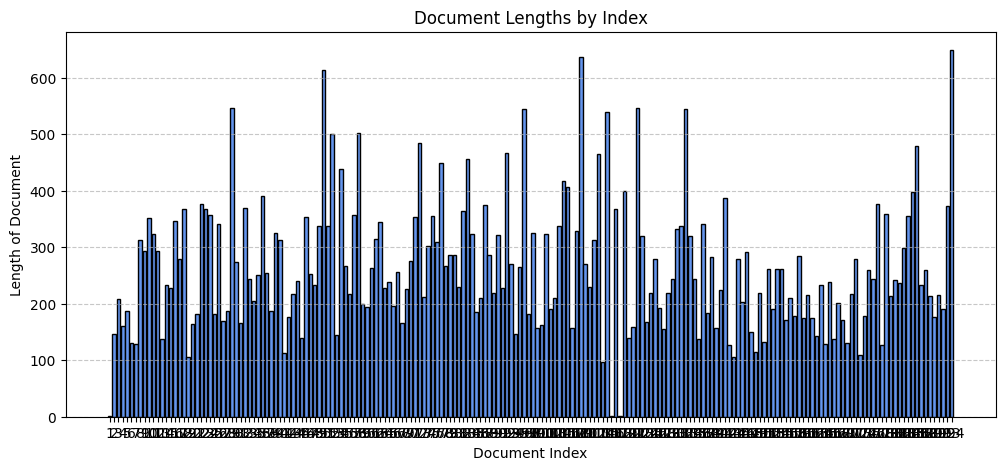

In [7]:
import matplotlib.pyplot as plt

# 각 문서 길이 계산 (문자 수 기준)
doc_lengths = [len(doc.page_content) for doc in langchain_docs]

# 문서 최소, 평균 길이 출력
print('문서의 최대 길이 :', max(doc_lengths))
print('문서의 최소 길이 :', min(doc_lengths))
print('문서의 평균 길이 :', sum(doc_lengths) / len(doc_lengths))

# 문서 인덱스 (1, 2, 3, …)
doc_indices = range(1, len(langchain_docs) + 1)

# 막대그래프 그리기
plt.figure(figsize=(12, 5))
plt.bar(doc_indices, doc_lengths, color='cornflowerblue', edgecolor='black')
plt.xlabel('Document Index')
plt.ylabel('Length of Document')
plt.title('Document Lengths by Index')
plt.xticks(doc_indices)  # 문서 번호 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
doc_lengths_10 = [doc for doc in langchain_docs if len(doc.page_content) < 10]

# 몇 개 있는지 출력
print(f"길이가 10 이하인 문서 개수: {len(doc_lengths_10)}")

길이가 10 이하인 문서 개수: 3


In [9]:
doc_lengths_10

[Document(metadata={'chunk_index': 1, 'category': '집'}, page_content='\ufeff'),
 Document(metadata={'chunk_index': '18-2', 'category': '사람'}, page_content='■'),
 Document(metadata={'chunk_index': '19-2', 'category': '사람'}, page_content='■')]

In [10]:
langchain_docs[0]

Document(metadata={'chunk_index': 1, 'category': '집'}, page_content='\ufeff')

In [11]:
# 기존 langchain_docs에서 길이가 10 이하인 문서 제거
langchain_docs = [doc for doc in langchain_docs if len(doc.page_content.strip()) > 10]

print(f"학습 데이터 문서 개수: {len(langchain_docs)}")

학습 데이터 문서 개수: 191


In [12]:
docs = [doc.page_content for doc in langchain_docs]
docs[0]

'1. 제목: HTP : 집 집은 일상생활에서의 가정생활, 또는 가족 내에서의 자신에 대한 인식을 나타낸다. 자신의 현실의 모습일 수도 있고, 또는 자신이 바라는 모습, 또는 가족의 생활패턴을 나타낸다. 지붕 지붕의 핵심은 머리로 상상할 수 있는 생각을 나타낸다.'

# 임베딩 모델

In [13]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoModelForCausalLM
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
# 파인튜닝된 임베딩 모델 로드
embedding_model_name = "HJUNN/bge-m3b-Art-Therapy-embedding-fine-tuning"
embed_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embed_model = AutoModel.from_pretrained(embedding_model_name).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
def get_embedding(text):
    """텍스트를 임베딩 벡터로 변환"""
    inputs = embed_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        emb = embed_model(**inputs).last_hidden_state[:,0,:]  # [CLS] 토큰
        emb = emb / emb.norm(dim=1, keepdim=True)  # 정규화
    return emb.cpu().numpy()


# 벡터 DB

In [15]:
# wrapper 만들기
from langchain.embeddings.base import Embeddings

class MyEmbeddings(Embeddings):
    def __init__(self, model, tokenizer, device="cpu"):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def embed_documents(self, texts):
        """리스트[str] -> 리스트[np.ndarray]"""
        return [self.embed_query(t) for t in texts]

    def embed_query(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(self.device)
        with torch.no_grad():
            emb = self.model(**inputs).last_hidden_state[:, 0, :]
            emb = emb / emb.norm(dim=1, keepdim=True)
        return emb.cpu().numpy()[0]



In [16]:
from langchain.vectorstores import Chroma

embeddings = MyEmbeddings(embed_model, embed_tokenizer, device=device)

# Chroma DB 생성
vectorstore = Chroma.from_documents(
    documents=langchain_docs,
    embedding=embeddings,
    collection_name="htp_collection",
    persist_directory="./chroma_store"
)

# 영구 저장
vectorstore.persist()

/tmp/ipython-input-813573252.py:14: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


# 크로스 인코더

In [17]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('BAAI/bge-reranker-v2-m3')

In [66]:
from typing import Any, List
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document

class Retriever_with_cross_encoder(BaseRetriever):
    vectorstore: Any
    crossencoder: Any
    k: int
    rerank_top_k: int

    @classmethod
    def from_params(
        cls,
        vectorstore: Any,
        crossencoder: Any,
        k: int = 5,
        rerank_top_k: int = 2
    ) -> "Retriever_with_cross_encoder":
        self = cls()
        self.vectorstore = vectorstore
        self.crossencoder = crossencoder
        self.k = k
        self.rerank_top_k = rerank_top_k
        return self

    def get_relevant_documents(self, query: str) -> List[Document]:
        # 첫번째 검색 결과 k개 (기본값=5)
        initial_docs = self.vectorstore.similarity_search(query, k=self.k)

        # pairs = 검색 문서와 검색어의 모든 쌍들
        pairs = [[query, doc.page_content] for doc in initial_docs]

        # 검색 문서와 검색어가 모두 입력으로 사용.
        scores = self.crossencoder.predict(pairs)
        scored_docs = sorted(zip(initial_docs, scores), key=lambda x: x[1], reverse=True)

        # 점수가 높은 top k만 남긴다. (기본값=2)
        return [doc for doc, _ in scored_docs[:self.rerank_top_k]]

    async def aget_relevant_documents(self, query: str) -> List[Document]:
        raise NotImplementedError

/tmp/ipython-input-2357254490.py:5: DeprecationWarning: Retrievers must implement abstract `_get_relevant_documents` method instead of `get_relevant_documents`
  class Retriever_with_cross_encoder(BaseRetriever):
/tmp/ipython-input-2357254490.py:5: DeprecationWarning: Retrievers must implement abstract `_aget_relevant_documents` method instead of `aget_relevant_documents`
  class Retriever_with_cross_encoder(BaseRetriever):


In [19]:
cross_encoder_retriever = Retriever_with_cross_encoder(
    vectorstore=vectorstore,
    crossencoder=cross_encoder,
    k=20,
    rerank_top_k=10
)

# LLM 모델

In [20]:
import os
from google.colab import userdata
from openai import OpenAI

# 환경 변수로 설정
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
client = OpenAI()

# 이전 대화를 고려한 쿼리 재생성


In [95]:
# 멀티 쿼리 재생성 모델 정의
class MultiQueryGenerator(BaseModel):
    queries : List[str] = Field(description= "사용자 질문에서 추출한 검색 쿼리 목록")

In [134]:
from re import template
# 수정이 필요한 AdvancedQueryRewriter 클래스의 프롬프트 템플릿 부분만 수정

class AdvancedQueryRewriter:
    def __init__(self, model_name = "gpt-4o", temperature = 0):
        self.llm = ChatOpenAI(temperature = temperature, model_name = model_name, max_tokens = 1000)
        self.parser = JsonOutputParser(pydantic_object = MultiQueryGenerator)

        # 프롬프트 템플릿 - 명확한 형식 지침 추가
        self.template = """
        당신은 사용자의 이전 대화와 질문을 기반으로 검색 쿼리를 재생성하세요.

        # 지침
        1. 아래의 history 에 포함된 모든 이전 질의/검색문서/답변을 참고하여 더 정확한 검색 쿼리를 생성하세요.
        2. 현재 질문이 모호하거나 생략된 경우, history 를 참고해 문맥상 완전한 쿼리로 재구성하세요.
        3. 이전 대화가 없거나 관련이 없는 경우 현재 질문만 사용하세요.
        4. 반드시 명확하고 검색에 적합한 쿼를 생성하세요.
        6. 출력은 재생성된 쿼리 문자열만 포함해야 합니다. 추가 설명이나 주석은 포함하지 마세요.
        7. 현재 문장이 여러 속성을 포함하고 있다면, 각각을 별도의 쿼리로 분리하세요.
        8. 각 쿼리는 독립적으로 벡터 DB에서 검색될 수 있도록 완전하고 명확해야 합니다.
        10. 분리된 쿼리들을 합쳤을 때 원래 쿼리의 의미를 나타낼 수 있도록 하세요.

        # 입력
        전체 대화: {history_text}
        현재 질문: {current_query}

        # 출력 형식
        반드시 아래의 JSON 형식으로 출력하세요:
        {{
            "queries" : ["쿼리1", "쿼리2", ...]
        }}

        예시 :
        현재 질문이 "서울은 ? 그리고 맛집은?"이고 이전 대화가 "한국의 관광지 추천해줘"라면,
        {{
            "queries" : ["서울의 관광지 추천해줘", "서울의 맛집 추천해줘"]
        }}

        단일 쿼리인 경우:
        {{
            "queries" : ["한국의 관광지 추천해줘"]
        }}

        {format_instructions}
        """
        self.prompt = PromptTemplate(
            input_variables = ["history_text", "current_query"],
            template = self.template
        )

    # rewrite_query 메서드는 그대로 유지
    def rewrite_query(self, history_text: str, current_query: str) -> List[str]:
        # 이전 대화가 없는 경우
        if not history_text.strip():
            history_text = "이전 대화 없음"

        try:
            # 프롬프트 준비
            format_instructions = self.parser.get_format_instructions()

            # 체인 실행
            formatted_prompt = self.prompt.format(
                history_text=history_text,
                current_query = current_query,
                format_instructions = format_instructions
            )

            # 직접 LLM  호출
            llm_response = self.llm.invoke(formatted_prompt)

            # JSON 직접 파싱 (파서 사용 대신)
            try:
                import json
                response_json = json.loads(llm_response.content)

                if "queries" in response_json and isinstance(response_json["queries"], list):
                    return response_json["queries"]
                else:
                    print(f"응답에 'quries' 리스트가 없습니다: {response_json}")
                    return [current_query]
            except json.JSONDecodeError as json_err:
                print(f"JSON 파싱 오류: {str(json_err)}")
                print(f"LLM 원본 응답 : {llm_response.content}")
                return [current_query]
        except Exception as e:
            print(f"쿼리 재생성 중 오류 발생: {str(e)}")
            print(f"LLM 원본 응답: {llm_response.content}")
            # 오류 발생 시 원래 쿼리 사용
            return [current_query]


### 5. 이전 대화를 고려한 쿼리 재생성 + 검색기 연걸

In [135]:
# 멀티 쿼리 검색 클래스 정의
class MultiQueryRetriever:
    def __init__(self, vectorstore, query_rewriter, **kwargs):
        self.vectorstore = vectorstore
        self.query_rewriter = query_rewriter
        self.history = []

    def build_history_text(self) -> str:
        text = ""
        for h in self.history:
            text += f"[QUESTION]\n{h['user_query']}\n"
            text += f"[REWRITTEN QUERIES]\n{h['rewritten_queries']}\n"
            text += "[RETRIEVED DOCS]\n"
            for d in h["retrieved_docs"]:
                text += f"- {d['content']}\n"
            text += f"[ANSWER]\n{h['final_answer']}\n"
            text += "-"*40 + "\n"
        return text

    def retrieve(self, query:str, num_docs = 3)-> List[Document]:

        history_text = self.build_history_text()

        rewritten_queries = self.query_rewriter.rewrite_query(
            history_text=history_text,
            current_query=query
        )

        print(f"원래 쿼리: {query}")
        print(f"재생성된 쿼리들: {rewritten_queries}")

        # 모든 쿼리에 대해 검색 수행 및 결과 병합
        all_docs = []
        seen_contents = set()

        # 다수의 쿼리가 주어졌을 때 1개씩 검색해본다.
        for idx, rewritten_query in enumerate(rewritten_queries):
            print(f"쿼리 {idx+1} : {rewritten_query}")

            #  벡터 검색 수행
            docs = self.vectorstore.similarity_search(rewritten_query, k = num_docs)

            # 중복 제거하여 문서 추가
            for doc in docs:
                if doc.page_content not in seen_contents:
                    seen_contents.add(doc.page_content)

                    #메타데이터에 쿼리 정보 추가
                    if not hasattr(doc, "metadata") or doc.metadata is None:
                        doc.metadata = {}
                    doc.metadata['query'] = rewritten_query
                    all_docs.append(doc)

        print(f"총 {len(all_docs)}개의 고유 문서를 검색했습니다.")
        return all_docs, rewritten_queries


### 6. RAG - 검색기와 답변 모듈의 연결

In [136]:
# RAG 응답 생성 클래스 정의
class AdvancedConversationalRAG:
    def __init__(self, vectorstore, model_name = "gpt-4o", temperature = 0.2):
        # history에 대화 저장
        self.history = []
        # 쿼리 재생성기
        self.query_rewriter = AdvancedQueryRewriter(model_name = model_name)
        # 각각의 검색어를 따로 검색한 뒤에 검색결과를 취합하는 멀티쿼리 리트리버
        self.retriever = MultiQueryRetriever(vectorstore=vectorstore, query_rewriter = self.query_rewriter)
        # 답변을 해줄 답변 용도의 LLM 객체
        self.llm = ChatOpenAI(temperature = temperature, model_name = model_name)

        # 응답 생성을 위한 프롬프트 템플릿
        self.response_template = """
        당신은 사용자 질문에 대한 정보를 제공하는 도우미입니다.

        사용자 질문 : {query}

        다음 정보를 참고하여 사용자 질문에 답변하세요:
        {context}

        참고사항:
        1. 사용자 질문에 여러 개의 질의가 포함되어 있다면, 각각에 대해 명확하게 답변하세요.
        2. 제공된 정보만을 사용하여 답변하세요. 정보가 부족하면 솔직하게 모른다고 답변하세요.
        3. 답변은 한국어로 제공하세요.
        4. 제공된 정보의 원본 출처가 있다면 인용해주세요.

        답변:
        """

        self.response_prompt = PromptTemplate(
            input_variables = ["query", "context"],
            template = self.response_template
        )
    def query(self, current_query: str) -> Dict:
        # 관련 문서검색
        docs, rewritten_queries = self.retriever.retrieve(current_query)

        # 문서 내용을 컨텍스트로 변환
        if docs:
            context = "\n\n".join([f"문서 {i+1} :\n {doc.page_content}" for i, doc in enumerate(docs)])
            formatted_prompt = self.response_prompt.format(query=current_query, context=context)
        else:
            # 문서 없으면 일반 지식 기반 답변 생성
            formatted_prompt = f"사용자 질문: {current_query}\n\n검색된 문서는 없지만, 적절하게 답변해 주세요."

        # 직접 LLM 호출
        result = self.llm.invoke(formatted_prompt)
        response = result.content

        # 재작성된 쿼리 가져오기


        # 히스토리에 저장
        record = {
            "user_query": current_query,
            "rewritten_queries": rewritten_queries,
            "retrieved_docs": [
                {"content": d.page_content, "metadata": d.metadata} for d in docs
            ],
            "final_answer": response
        }
        self.history.append(record)
        self.retriever.history.append(record)



        # 결과 반환
        return {
            "query" : current_query,
            "result" : response,
            "rewritten_queries": rewritten_queries,
            "source_documents" : docs
        }

In [137]:
conversational_rag = AdvancedConversationalRAG(vectorstore)

In [142]:
# 예시 1: 첫 번째 질문 (이전 대화 없음)
query1 = "손이 크고, 눈썹이 진한 사람 그림"
print("\n" + "="*50)
print(f"질문 1: {query1}")
result1 = conversational_rag.query(query1)
print(f"답변 1:\n{result1['result']}")


질문 1: 손이 크고, 눈썹이 진한 사람 그림
JSON 파싱 오류: Expecting value: line 1 column 1 (char 0)
LLM 원본 응답 : ```json
{
    "queries": ["손이 큰 사람 그림", "눈썹이 진한 사람 그림"]
}
```
원래 쿼리: 손이 크고, 눈썹이 진한 사람 그림
재생성된 쿼리들: ['손이 크고, 눈썹이 진한 사람 그림']
쿼리 1 : 손이 크고, 눈썹이 진한 사람 그림
총 3개의 고유 문서를 검색했습니다.
답변 1:
사용자 질문에 대한 답변은 다음과 같습니다:

1. **손이 큰 사람 그림**: 문서 1과 문서 2에 따르면, 손의 크기나 형태는 그린 사람의 심리 상태를 반영할 수 있습니다. 예를 들어, 매우 큰 손가락을 그리는 것은 공격적인 면모가 존재하거나, 죄책감을 가지고 있을 수 있음을 나타낼 수 있습니다. 또한, 손에 덧칠을 하는 것은 공격적인 충동이나 불안함을 느끼고 있을 수 있음을 시사합니다.

2. **눈썹이 진한 사람 그림**: 문서 3에 따르면, 빽빽하고 덥수룩한 눈썹을 그리는 것은 본능에 따라 행동하고, 거칠고 자제력이 없으며, 항상 무언가를 의심하는 성향을 나타낼 수 있습니다. 이러한 사람은 타인에게 거만하게 보일 수 있습니다.

제공된 정보에 기반하여, 손이 크고 눈썹이 진한 사람을 그리는 것은 공격적이거나 불안한 심리 상태와 본능적이고 자제력이 부족한 성향을 동시에 나타낼 수 있습니다.


In [143]:
# 예시 2: 두 번째 질문
query2 = "손가락을 자세히 나타냈어"
print("\n" + "="*50)
print(f"질문 2: {query2}")
result2 = conversational_rag.query(query2)
print(f"답변 2:\n{result2['result']}")


질문 2: 손가락을 자세히 나타냈어
JSON 파싱 오류: Expecting value: line 1 column 1 (char 0)
LLM 원본 응답 : ```json
{
    "queries": ["손가락을 자세히 나타낸 그림"]
}
```
원래 쿼리: 손가락을 자세히 나타냈어
재생성된 쿼리들: ['손가락을 자세히 나타냈어']
쿼리 1 : 손가락을 자세히 나타냈어
총 3개의 고유 문서를 검색했습니다.
답변 2:
사용자 질문 "손가락을 자세히 나타냈어"에 대한 답변은 다음과 같습니다:

문서 1에 따르면, 손가락은 손에서 이어지는 부분으로, 에너지를 발산하는 장소입니다. 손가락을 자세히 그리는 것은 손에 담긴 에너지가 건설적인지, 공격적이고 파괴적인지를 파악할 필요가 있음을 시사합니다. 많은 아동이 손보다 손가락을 더 많이 그리는 경향이 있다고 합니다.

문서 3에서는 손가락을 자세히 그리면서 선으로 빙 둘러 놓는 경우, 공격적인 면모를 억누르고 숨기려는 경향이 있다고 설명합니다. 이는 자신이 날카롭고 공격적으로 보이는 것을 막기 위한 행동일 수 있습니다.

따라서, 손가락을 자세히 나타내는 것은 그 사람의 내면의 에너지 상태나 감정 상태를 반영할 수 있으며, 이는 건설적일 수도 있고 공격적일 수도 있습니다.


In [144]:
# 예시 3: 세 번째 질문
query3 = "창문이 크게 있어"
print("\n" + "="*50)
print(f"질문 3: {query3}")
result3 = conversational_rag.query(query3)
print(f"\n답변 3:\n{result3['result']}")

# 인용한 문서 확인
print("\n" + "="*50)
print("\n참조 문서들:")
for i, doc in enumerate(result3['source_documents'], 3):
    print(f"\n문서 {i}:")
    print(doc.page_content)
    print("메타데이터:", doc.metadata)


질문 3: 창문이 크게 있어
JSON 파싱 오류: Expecting value: line 1 column 1 (char 0)
LLM 원본 응답 : ```json
{
    "queries": ["창문이 크게 있는 그림"]
}
```
원래 쿼리: 창문이 크게 있어
재생성된 쿼리들: ['창문이 크게 있어']
쿼리 1 : 창문이 크게 있어
총 3개의 고유 문서를 검색했습니다.

답변 3:
사용자 질문 "창문이 크게 있어"에 대한 답변은 다음과 같습니다:

문서 1과 문서 2에 따르면, 창문은 대인관계와 외부 환경에 대한 인식을 나타낼 수 있습니다. 창문이 크게 있다는 것은 많은 사람과의 대인관계를 가지고 있음을 나타낼 수 있으며, 외부 환경을 잘 인식하고 있다는 자신감의 표현일 수 있습니다. 또한, 창문이 크다는 것은 '나'라는 존재를 다른 사람 앞에서 과시하고 표현하고 싶다는 의미로 해석될 수 있습니다. 

하지만, 문서 3에서는 창문이 강조되거나 장식이 많을 경우, 인간관계에 대한 과한 걱정이나 정신적인 어려움을 겪고 있을 가능성이 있다고 언급하고 있습니다. 따라서 창문이 크게 있다는 것만으로는 다양한 해석이 가능하며, 구체적인 상황에 따라 다르게 해석될 수 있습니다. 

이 정보는 제공된 문서의 내용을 바탕으로 한 것이며, 추가적인 정보가 필요하다면 다른 자료를 참고해야 할 수도 있습니다.


참조 문서들:

문서 3:
■ 창문의 갯수가 매우 많다 '나'라는 존재를 다른 사람 앞에서 과시하고 표현하고 싶다는 표현일 수 있다. 성적인 표현이 존재하는 경우, 성적으로 노출증 및 사회적으로 옷을 적절히 입지 않고 자신의 신체 일부를 드러냄으로써 성적인 만족감을 가지는 경우가 존재한다. 단 이것이 성적기호를 결정짓는 판단기준이 되어서는 안 된다 많은 사람과 대인관계를 가지고 있다는 표시가 될 수 있다 만약 창문에 어떠한 장식(창문 턱, 덧문, 또는 창틀)이 없는 경우, 세상을 살아감에 있어 당당히 나아갈 준비가 되어있다는 자신감의 표시가 된다 만약 창문에 어떠한 장

In [139]:
conversational_rag.history

[{'user_query': '손이 크고, 눈썹이 진한 사람 그림',
  'rewritten_queries': ['손이 크고, 눈썹이 진한 사람 그림'],
  'retrieved_docs': [{'content': '■ 성인이 손이 없이 손가락만 그린다 어린아이처럼 떼를 쓰고 어리광을 피우고 싶어한다 어린아이 때에 부당한 일을 겪었다 매우 큰 손가락을 그린다 공격적인 면모가 존재한다 심하게 덧칠하여 강조한 손가락을 그린다 절도 및 자위행위와 관련된 죄책감을 가지고 있다',
    'metadata': {'chunk_index': '24-9',
     'category': '사람',
     'query': '손이 크고, 눈썹이 진한 사람 그림'}},
   {'content': '* 손 손은 직접적으로 표현되는 팔 끝의 동작부위입니다. 팔이 나와 다른사람을 이어주는 행동부위라면, 손은 구체적으로 어떤 행동을 하는지를 보여주는 곳이라 할 수 있겠습니다. 손이 때로는 나의 감정을 보여주는 좋은 단서가 됩니다. 흐릿하고 알아보기 힘든 손을 그린다 사회적인 활동 및 무언가 활발히 활동해야 할 때에 자신감이 부족하다 손에 덧칠을 한다 공격적인 충동이나 무언가 에너지 넘치는 활동을 불안해 한다 청소년의 경우, 자위행위와 관련된 죄책감을 가지는 경우가 많다 현재 불안함을 느끼고 있을 수 있다',
    'metadata': {'category': '사람',
     'chunk_index': '24-5',
     'query': '손이 크고, 눈썹이 진한 사람 그림'}},
   {'content': '■ 빽빽하고 덥수룩한 눈썹을 그린다 본능에 따라 행동한다 거칠고 자제력이 없다 치켜올린 눈썹을 그린다 무언가를 경멸한다 타인에게 있어서 거만한 사람으로 보일 수 있다 항상 무언가를 의심한다',
    'metadata': {'category': '사람',
     'chunk_index': '22-17',
     'query': '손이 크고, 눈썹이 진한 사람 그림'}}]

In [79]:
!pip install gradio